In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.express as px
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier
from dateutil.relativedelta import relativedelta
import datetime as dt

In [2]:
frac_ticks_df = pd.read_csv('frac_ticks.csv')
frac_ticks_df = frac_ticks_df[frac_ticks_df.ticker_type == 'etf']
frac_ticks_df = frac_ticks_df[frac_ticks_df.symbol.notna()]
frac_ticks = frac_ticks_df.symbol.to_list()

In [3]:
frac_ticks_info_df = pd.read_csv('frac_ticks_infos.csv')

cols = ['symbol', 'name', 'FUND_TOTAL_ASSETS', 'FUND_LEVERAGE', 'FUND_ASSET_CLASS_FOCUS', 'FUND_MGR_STATED_FEE', 'INVERSE_FUND_INDICATOR']
frac_ticks_info_df = frac_ticks_info_df[cols]
frac_ticks_info_df = frac_ticks_info_df[frac_ticks_info_df.FUND_LEVERAGE == 'N']
frac_ticks_info_df = frac_ticks_info_df[frac_ticks_info_df.INVERSE_FUND_INDICATOR == 'N']
frac_ticks_info_df.drop(['FUND_LEVERAGE', 'INVERSE_FUND_INDICATOR'], axis=1, inplace=True)
frac_ticks_info_df.set_index('symbol', inplace=True)

bond_ticks = frac_ticks_info_df[frac_ticks_info_df.FUND_ASSET_CLASS_FOCUS == 'Fixed Income'].index.to_list()
equity_ticks = frac_ticks_info_df[frac_ticks_info_df.FUND_ASSET_CLASS_FOCUS == 'Equity'].index.to_list()

In [9]:
aum_top200 = frac_ticks_info_df.sort_values('FUND_TOTAL_ASSETS', ascending=False).head(200).index

In [4]:
tickers = yf.Tickers(frac_ticks)
tickers_data = tickers.download(period='30y')
dvd_rate = tickers_data['Dividends'] / tickers_data['Close']
dvd_rate = dvd_rate[(dvd_rate > 0).sum(axis=1) != 0]

[*********************100%***********************]  897 of 897 completed


In [8]:
yearly_rates = []
for symbol in dvd_rate.columns:
    yearly_rates.append(dvd_rate[symbol].dropna().resample('m').sum().rolling(12).sum())
yearly_rates = pd.concat(yearly_rates, axis=1)

In [6]:
dvd_sharpes = pd.DataFrame(index=yearly_rates.columns, columns=['mean', 'sharpe'])
for symbol in yearly_rates.columns:
    rate = yearly_rates[symbol].dropna()
    mean = rate.mean()
    dvd_sharpe = mean / rate.std()
    dvd_sharpes.loc[symbol, 'mean'] = mean
    dvd_sharpes.loc[symbol, 'sharpe'] = dvd_sharpe

/var/folders/df/58mn713n66n7_8qfjg_nl_qw0000gn/T/ipykernel_76372/468369057.py:5: RuntimeWarning: invalid value encountered in double_scalars
  dvd_sharpe = mean / rate.std()


In [7]:
dvd_sharpes.loc['BNDX']

mean      0.024368
sharpe      2.7358
Name: BNDX, dtype: object

In [10]:
dvd_sharpe_top50 = set(dvd_sharpes.loc[aum_top200].sort_values('sharpe', ascending=False).dropna().head(50).index)
dvd_mean_top50 = set(dvd_sharpes.loc[aum_top200].sort_values('mean', ascending=False).dropna().head(50).index)
select_ticks = dvd_mean_top50.union(dvd_sharpe_top50)

In [11]:
frac_ticks_info_df = pd.concat([frac_ticks_info_df, dvd_sharpes.loc[select_ticks]], axis=1, join='inner')

/var/folders/df/58mn713n66n7_8qfjg_nl_qw0000gn/T/ipykernel_76372/2321399404.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  frac_ticks_info_df = pd.concat([frac_ticks_info_df, dvd_sharpes.loc[select_ticks]], axis=1, join='inner')


In [13]:
frac_ticks_info_df[frac_ticks_info_df.FUND_ASSET_CLASS_FOCUS == 'Fixed Income']

,name,FUND_TOTAL_ASSETS,FUND_ASSET_CLASS_FOCUS,FUND_MGR_STATED_FEE,mean,sharpe
BND,先锋领航总体债券市场ETF,92509.203130,Fixed Income,0.03,0.038997,2.699961
AGG,iShares安硕核心美国综合债券ETF,91135.765630,Fixed Income,0.03,0.043243,2.201737
VCIT,领航长期公司债券ETF,39859.968750,Fixed Income,0.03,0.043611,3.893585
TLT,iShares安硕20年期以上美国国债,38589.863280,Fixed Income,0.15,0.047666,1.91342
VCSH,先锋领航短期公司债ETF,35520.644530,Fixed Income,0.05,0.026207,6.207261
LQD,iShares安硕iBoxx美元投资级公司,35345.113280,Fixed Income,0.14,0.06731,1.875944
MUB,iShares安硕国家地方债ETF,32281.121090,Fixed Income,0.07,0.033773,2.976492
IEF,iShares安硕7-10年国债ETF,28449.472660,Fixed Income,0.15,0.038468,1.497606
VTEB,领航免税债券指数ETF,27017.960000,Fixed Income,0.06,0.021597,6.986444
MBB,iShares安硕抵押担保证券ETF,26600.097660,Fixed Income,0.04,0.034776,1.820851


In [14]:
start_date = tickers_data['Volume'].apply(lambda x: x.dropna().index.min(), axis=0)
start_date.name = 'start_date'

In [15]:
mean_volume = tickers_data['Volume'].dropna(how='any').mean(axis=0)
mean_volume.name = 'mean_volume'

In [15]:
yearly_dvd_rate = dvd_rate.resample('Y').sum()

In [16]:
mean_dvd_rates = pd.Series(index=dvd_rate.columns, name='dvd_rate')
for symbol in dvd_rate.columns:
    mean_dvd_rate = dvd_rate[symbol].dropna().resample('Y').sum().mean()
    mean_dvd_rates.loc[symbol] = mean_dvd_rate


/var/folders/df/58mn713n66n7_8qfjg_nl_qw0000gn/T/ipykernel_76372/2900413593.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mean_dvd_rates = pd.Series(index=dvd_rate.columns, name='dvd_rate')


In [17]:
frac_ticks_df.set_index('symbol', inplace=True)

In [18]:
frac_ticks_df = pd.concat([frac_ticks_df, mean_dvd_rates], axis=1)

In [19]:
frac_ticks_df = pd.concat([frac_ticks_df, start_date], axis=1)
# frac_ticks_df.sort_values('dvd_rate', ascending=False).head(20)

In [20]:
frac_ticks_df = pd.concat([frac_ticks_df, mean_volume], axis=1)
frac_ticks_df.sort_values('dvd_rate', ascending=False).head(20)

,ticker_type,ticker_id,name,dvd_rate,start_date,mean_volume
XLG,etf,913243920,Invesco S&P 500 Top 50 ETF,1.593061,2005-05-10,7.716266e+05
AMZA,etf,913243441,InfraCap MLP ETF,0.291252,2014-10-02,7.518506e+04
REM,etf,913244609,iShares Mortgage Real Estate ETF,0.279144,2007-05-04,1.078811e+06
PRF,etf,913244564,Invesco FTSE RAFI US 1000 ETF,0.217821,2005-12-20,7.764398e+05
KBWD,etf,913243184,Invesco KBW High Dividend Yield Financial ETF,0.160611,2010-12-02,1.185739e+05
YYY,etf,913246366,Amplify High Income ETF,0.157026,2012-06-12,1.510701e+05
QYLD,etf,913246309,Global X NASDAQ 100 Covered Call ETF,0.155992,2013-12-12,5.154497e+06
BIZD,etf,913243022,VanEck BDC Income ETF,0.138899,2013-02-12,2.901029e+05
PCEF,etf,913247160,Invesco CEF Income Composite ETF,0.135912,2010-02-19,1.617058e+05
RYLD,etf,950122535,Global X Russell 2000 Covered Call ETF,0.131385,2019-04-22,8.657983e+05


In [24]:
frac_ticks_df

,ticker_type,ticker_id,name,dvd_rate,start_date,mean_volume
HYG,etf,913242920,iShares iBoxx $ High Yield Corporate Bond ETF,0.105661,2007-04-11,4.094820e+07
CIBR,etf,913242924,First Trust NASDAQ Cybersecurity ETF,0.004686,2015-07-07,9.435382e+05
SNLN,etf,913242927,Highland iBoxx Senior Loan ETF,0.000000,2012-11-07,1.808468e+04
IBUY,etf,913242930,Amplify Online Retail ETF,0.000364,2016-04-20,6.466017e+04
XSW,etf,913242937,SPDR S&P Software & Services ETF,0.007637,2011-09-29,2.509959e+04
...,...,...,...,...,...,...
BKCH,etf,950186773,Global X Blockchain ETF,0.019142,2021-07-14,4.018672e+04
CRPT,etf,950188242,First Trust SkyBridge Crypto Industry & Digita...,0.003673,2021-09-21,6.331328e+04
PINK,etf,950188674,Simplify Health Care ETF,0.003934,2021-10-08,6.694191e+04
BITO,etf,950188842,ProShares Bitcoin Strategy ETF,0.025182,2021-10-20,7.800958e+06


In [23]:
selected_ticks_df = frac_ticks_df[(frac_ticks_df.dvd_rate > frac_ticks_df.dvd_rate.quantile(0.8)) & (frac_ticks_df.FUND_TOTAL_ASSETS > frac_ticks_df.FUND_TOTAL_ASSETS.quantile(0.8))]

AttributeError: 'DataFrame' object has no attribute 'FUND_TOTAL_ASSETS'

In [21]:
selected_ticks_df = frac_ticks_info_df[(frac_ticks_info_df.dvd_rate > frac_ticks_info_df.dvd_rate.quantile(0.8)) & (frac_ticks_info_df.FUND_TOTAL_ASSETS > frac_ticks_info_df.FUND_TOTAL_ASSETS.quantile(0.8))]

AttributeError: 'DataFrame' object has no attribute 'dvd_rate'

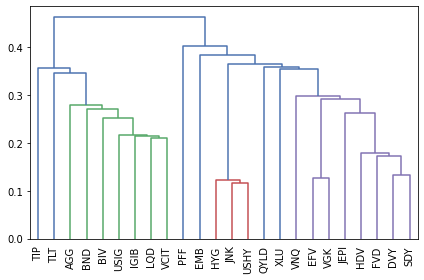

In [158]:
from pypfopt import plotting

plotting.plot_dendrogram(hrp); 

In [138]:
selected_ticks_df[['name', 'dvd_rate', 'FUND_TOTAL_ASSETS', 'FUND_ASSET_CLASS_FOCUS', 'start_date', 'FUND_MGR_STATED_FEE']].sort_values(['dvd_rate'], ascending=False)

,name,name,dvd_rate,FUND_TOTAL_ASSETS,FUND_ASSET_CLASS_FOCUS,start_date,FUND_MGR_STATED_FEE
QYLD,Global X NASDAQ 100 Covered Call ETF,Global X Nasdaq 100 Covered Ca,0.146285,7598.044000,Equity,2013-12-12,0.6000
JNK,SPDR Bloomberg High Yield Bond ETF,SPDR彭博高收益债券ETF,0.116806,8281.984375,Fixed Income,2007-12-04,0.4000
HYG,iShares iBoxx $ High Yield Corporate Bond ETF,iShares安硕iBoxx高收益公司债ET,0.102472,15492.330000,Fixed Income,2007-04-11,0.4800
PFF,iShares Preferred & Income Securities ETF,iShares安硕优先股和收益证券ETF,0.100399,12758.880000,Fixed Income,2007-03-30,0.4500
JEPI,JPMorgan Equity Premium Income ETF,JPMorgan Equity Premium Income,0.076216,26208.652340,Equity,2020-05-21,0.3500
EMB,iShares JP Morgan USD Emerging Markets Bond ETF,iShares安硕摩根大通美元新兴市,0.063927,14336.957030,Fixed Income,2007-12-19,0.3900
LQD,iShares iBoxx $ Investment Grade Corporate Bon...,iShares安硕iBoxx美元投资级公司,0.063739,35345.113280,Fixed Income,2002-07-30,0.1400
VNQ,Vanguard Real Estate ETF,Vanguard房地产ETF,0.062110,30803.660000,Equity,2004-09-29,0.1200
FVD,First Trust Value Line Dividend Index Fund,第一信托超值系列红利指数基金,0.056934,11689.240000,Equity,2003-08-27,0.5000
USHY,iShares Broad USD High Yield Corporate Bond ETF,iShares Broad USD High Yield C,0.052826,8782.674000,Fixed Income,2017-10-26,0.2200


In [141]:
selected_ticks = list(selected_ticks_df.index)
ohlc = yf.download(selected_ticks, period="30y")
prices = ohlc['Adj Close'].dropna(how='all')

[*********************100%***********************]  24 of 24 completed


In [159]:
mu = expected_returns.mean_historical_return(prices)

In [161]:
mu.sort_values()

USHY    0.026108
BND     0.028644
AGG     0.029605
PFF     0.032404
EFV     0.033757
IGIB    0.034461
TIP     0.034950
USIG    0.036667
BIV     0.036832
EMB     0.037202
VCIT    0.039022
JNK     0.042695
HYG     0.042916
TLT     0.045090
LQD     0.046023
VGK     0.047852
QYLD    0.067128
XLU     0.068976
VNQ     0.072517
DVY     0.078681
SDY     0.086720
FVD     0.093235
HDV     0.094430
JEPI    0.125737
dtype: float64

In [144]:
cov = risk_models.sample_cov(prices)

/Users/fantasycheng/miniforge3/envs/kaggle_env/lib/python3.8/site-packages/pypfopt/risk_models.py:68: UserWarning:

The covariance matrix is non positive semidefinite. Amending eigenvalues.



In [147]:
sigma = np.sqrt(np.diag(cov))

In [152]:
corr = cov / np.outer(sigma, sigma)

In [162]:
hd_ticks = ['HDV', 'SDY', 'FVD', 'DVY']
corr.loc[hd_ticks, hd_ticks]

,HDV,SDY,FVD,DVY
HDV,1.000000,0.786325,0.839414,0.819751
SDY,0.786325,1.000000,0.955024,0.980709
FVD,0.839414,0.955024,1.000000,0.932064
DVY,0.819751,0.980709,0.932064,1.000000


In [154]:
px.imshow(corr)

In [164]:
bond_tickers = ['BND', 'EMB', 'HYG', 'TIP', 'TLT', 'LQD', 'BIV', 'PFF']
equity_tickers = ['XLU', 'VNQ', 'SDY', 'HDV']

In [165]:
stable_ticks = bond_tickers
higher_ticks = bond_tickers + equity_tickers

In [166]:
stable_prices = prices[stable_ticks]
higher_prices = prices[higher_ticks]

In [167]:
from pypfopt import HRPOpt

rets = expected_returns.returns_from_prices(stable_prices)
hrp = HRPOpt(rets)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('BND', 0.23872),
             ('EMB', 0.08677),
             ('HYG', 0.06665),
             ('TIP', 0.15832),
             ('TLT', 0.03114),
             ('LQD', 0.08834),
             ('BIV', 0.30739),
             ('PFF', 0.02266)])

In [168]:
rets = expected_returns.returns_from_prices(higher_prices)
hrp = HRPOpt(rets)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('BND', 0.29607),
             ('EMB', 0.04986),
             ('HYG', 0.05403),
             ('TIP', 0.15858),
             ('TLT', 0.03085),
             ('LQD', 0.13414),
             ('BIV', 0.17665),
             ('PFF', 0.02665),
             ('XLU', 0.01913),
             ('VNQ', 0.01217),
             ('SDY', 0.01546),
             ('HDV', 0.02641)])

In [156]:
hrp.portfolio_performance(verbose=True);


Expected annual return: 4.3%
Annual volatility: 5.4%
Sharpe Ratio: 0.42


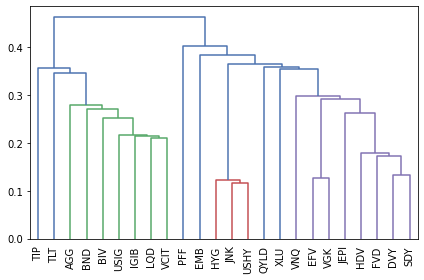

In [31]:
frac_ticks_df[(frac_ticks_df.dvd_rate > frac_ticks_df.dvd_rate.quantile(0.8)) & (frac_ticks_df.mean_volume > frac_ticks_df.mean_volume.quantile(0.8))].sort_values(['dvd_rate', 'mean_volume'])

,ticker_type,ticker_id,name,dvd_rate,start_date,mean_volume
IEF,etf,913243140,iShares 7-10 Year Treasury Bond ETF,0.037435,2002-07-30,7.789057e+06
BND,etf,913242959,Vanguard Total Bond Market ETF,0.038036,2007-04-10,7.145629e+06
SPAB,etf,913247161,SPDR Portfolio Aggregate Bond ETF,0.038405,2007-05-30,3.093268e+06
EWT,etf,913243136,iShares MSCI Taiwan ETF,0.040599,2000-06-23,4.081888e+06
VCIT,etf,913243285,Vanguard Intermediate-Term Corporate Bond ETF,0.040727,2009-11-23,6.864897e+06
AGG,etf,913243907,iShares Core U.S. Aggregate Bond ETF,0.041104,2003-09-29,8.396519e+06
TIP,etf,913243809,iShares TIPS Bond ETF,0.041182,2003-12-05,4.824881e+06
FEZ,etf,913243857,SPDR EURO STOXX 50 ETF,0.042707,2002-10-21,3.577760e+06
EWC,etf,913243131,iShares MSCI Canada ETF,0.044091,1996-03-18,5.586614e+06
EWH,etf,913243102,iShares MSCI Hong Kong ETF,0.044304,1996-03-18,4.038926e+06


In [27]:
px.scatter(frac_ticks_df[['mean_volume', 'dvd_rate']], log_x=True)

In [ ]:
p

In [ ]:
frac_ticks_df

In [54]:
mean_dvd_rates.sort_values(ascending=False).head(50)

AMZA    0.277650
REM     0.263033
KBWD    0.151428
YYY     0.147250
QYLD    0.146285
BIZD    0.138899
PCEF    0.129016
SDIV    0.122793
JNK     0.116806
AMLP    0.116001
RYLD    0.115548
MLPA    0.110802
HYG     0.102472
PGF     0.102421
PFF     0.100399
AMJ     0.099475
PGX     0.099398
SRET    0.098518
PDBC    0.098250
PFFA    0.097536
KBA     0.096147
PSP     0.091140
COMT    0.090331
KBWY    0.090230
SPFF    0.088380
PSK     0.085803
DIV     0.085586
BCI     0.080704
IDV     0.079140
HYEM    0.077499
JEPI    0.076216
PCY     0.075941
EWM     0.075531
DWX     0.074675
MDIV    0.073842
PHB     0.073609
EWI     0.072109
PFXF    0.071360
EWA     0.070960
HEWJ    0.070748
DVYE    0.070543
HYLS    0.070353
SJNK    0.070088
FGD     0.070080
EWD     0.069947
IFGL    0.069897
EDV     0.069797
EMLC    0.069432
RWX     0.069099
ANGL    0.068990
dtype: float64

In [49]:
dvd_rate

,AAAU,AAXJ,ACES,ACWI,ACWV,ACWX,AGG,AGGY,AGQ,AGZ,...,XSOE,XSW,XT,XTN,XYLD,YANG,YINN,YOLO,YYY,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
1993-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003029,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2023-05-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2023-05-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010667,0.0


In [2]:
import pymongo

class MONGOCONFIG():
    servers = "docdb-test.cluster-ckohxl2wcnzb.docdb.cn-northwest-1.amazonaws.com.cn"
    USERNAME = "dev"
    PASSWORD = "dev"
    client = pymongo.MongoClient(f"mongodb://{USERNAME}:{PASSWORD}@{servers}")

def read_table(db, table, limit=None, filter=None, sort_col='date'):
    if filter is None:
        filter = {}
    if limit is None:
        df = pd.DataFrame(list(db[table].find(filter, {'_id': 0})))
    else:
        df = pd.DataFrame(list(db[table].find(filter, {'_id': 0}).sort(sort_col, pymongo.DESCENDING).limit(limit)))
    if len(df) == 0:
        raise ValueError(f'Load table error: no data in table "{table}"')
    return df

client = MONGOCONFIG().client
db = client['wm_data_provider']

In [3]:
fract_etf_df = read_table(db, 't_etf_fractional')

In [20]:
frac_etf_tick_ids = fract_etf_df[fract_etf_df.date == fract_etf_df.date.max()].ticker_id.to_list()

In [15]:
latest_date = read_table(db, 't_bd_etf_basic_daily', limit=1).date[0]
etf_basic_df = read_table(db, 't_bd_etf_basic_daily', filter={'date': latest_date})

In [24]:
etf_basic_df.set_index('ticker_id', inplace=True)

In [26]:
frac_etf_tick_ids[0]

950160803

In [30]:
frac_etf_basic_df = etf_basic_df.reindex(frac_etf_tick_ids)

In [2]:
income_tickers = ['BND', 'BNDX', 'EMB', 'SPLB', 'HYG', 'TLT', 'TIP', 'PFF', 'VNQ']

In [3]:
# hyg = yf.Ticker("HYG")
ohlc = yf.download(income_tickers, period="30y")
prices = ohlc['Adj Close'].dropna(how='all')

[*********************100%***********************]  9 of 9 completed


In [5]:
def get_income_weights_over_threshold(mu, cov, threshold=0.05, min_value=0.01):
    tickers = mu.index
    no_constraint_tickers = list(tickers)
    min_constraint_tickers = []
    max_constraint_tickers = ['VNQ', 'PFF']
    
    train_cov = mu.copy()
    train_cov = cov.copy()
    while True:
        # try:
        train_mu = mu.loc[no_constraint_tickers]
        train_cov = cov.loc[no_constraint_tickers, no_constraint_tickers]
        ef = EfficientFrontier(train_mu, train_cov)
        for ticker in min_constraint_tickers:
            ticker_idx = ef.tickers.index(ticker)
            ef.add_constraint(lambda w: w[ticker_idx] >= threshold)
        
        for ticker in max_constraint_tickers:
            if ticker in no_constraint_tickers:
                ticker_idx = ef.tickers.index(ticker)
                ef.add_constraint(lambda w: w[ticker_idx] <= 0.15)

        ef.max_sharpe()
        weight = pd.Series(ef.weights, index=no_constraint_tickers)

        if (weight < min_value).sum() != 0:
            for ticker in weight[weight < min_value].index:
                no_constraint_tickers.remove(ticker)

        elif (weight < threshold).sum() > 1:
            ticker = weight.index[weight.argmin()]
            no_constraint_tickers.remove(ticker)

        elif (weight < threshold).sum() == 1:
            ticker = weight.index[weight.argmin()]
            min_constraint_tickers.append(ticker)
        else:
            break
    
    return np.array(weight.reindex(tickers).fillna(0))

def get_round_weights(weights, digits=4):
    round_weights = weights.apply(lambda x: round(x, digits))
    diff = 1 - round_weights.sum(axis=1)
    argmax_idx = round_weights.apply(lambda x: x.argmax(), axis=1)
    for date in round_weights.index:
        round_weights.loc[date].iloc[argmax_idx.loc[date]] += diff.loc[date]
    return round_weights


In [43]:
latest_date = prices.index.max()
idx = pd.IndexSlice

return_method = "capm_return"
risk_method = "sample_cov"

all_weights = {}

stable_tickers = ['BND', 'BNDX', 'EMB', 'SPLB', 'HYG', 'TIP']
higher_tickers = stable_tickers + ['PFF', 'VNQ']

tickers_dict = {'stable': stable_tickers, 'higher': higher_tickers}

for income_name, tickers in tickers_dict.items():
    train_end_time = pd.Timestamp("2015-01-01")
    all_train_end_time = []
    weights = []

    while train_end_time < latest_date:
        train_datasets = prices.loc[idx[:train_end_time], tickers]
        train_mu = expected_returns.return_model(train_datasets, method=return_method)
        train_cov = risk_models.risk_matrix(train_datasets, method=risk_method)

        train_weight = get_income_weights_over_threshold(train_mu, train_cov)
        weights.append(train_weight)

        all_train_end_time.append(train_end_time)
        train_end_time += relativedelta(months=1)
    
    weights = pd.DataFrame(weights, index=all_train_end_time, columns=tickers)
    weights = get_round_weights(weights)
    weights.index.name = 'Date'
    all_weights[income_name] = weights

In [ ]:
ticker_id_dict = {}
ticker_name_dict = {}
asset_type_dict = {}

for ticker in prices.columns:
    ticker_id, ticker_name, asset_type = get_ticker_info(db, ticker)
    ticker_id_dict[ticker] = ticker_id
    ticker_name_dict[ticker] = ticker_name
    asset_type_dict[ticker] = asset_type

In [46]:
test_select_prices = prices.iloc[prices.index.searchsorted(all_train_end_time)].append(prices.iloc[-1])
test_select_rets = test_select_prices.pct_change().dropna()

net_values = []
for key, weight in all_weights.items():
    weight.index = test_select_rets.index
    net_value = ((test_select_rets[weight.columns] * weight).sum(axis=1) + 1).cumprod()
    net_values.append(net_value)
net_values = pd.concat(net_values, axis=1)
net_values.columns = all_weights.keys()

start_df = pd.DataFrame(1, index=[pd.Timestamp("2015-01-01")], columns=net_values.columns)
net_values = pd.concat([start_df, net_values])

/var/folders/df/58mn713n66n7_8qfjg_nl_qw0000gn/T/ipykernel_8905/3100803926.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_select_prices = prices.iloc[prices.index.searchsorted(all_train_end_time)].append(prices.iloc[-1])


In [54]:
import plotly.express as px
px.line(net_values)

In [57]:
evaluate_strategy_returns(net_values, no_risk_rate=0.00)

(stable    0.019800
 higher    0.024042
 dtype: float64,
 stable    0.287312
 higher    0.285962
 dtype: float64,
 stable   -0.176834
 higher   -0.182442
 dtype: float64,
 stable    0.111968
 higher    0.131779
 dtype: float64)

In [49]:
def evaluate_strategy_returns(df, no_risk_rate=0.02):
    # 计算年化收益率
    total_return = (df.iloc[-1] / df.iloc[0]) ** (12/len(df)) - 1
    
    # 计算年化波动率
    annualized_volatility = np.std(df.pct_change()) * np.sqrt(12)
    
    # 计算夏普比率
    sharpe_ratio = (total_return - no_risk_rate) / annualized_volatility  # 假设无风险利率为2%
    
    # 计算最大回撤
    cummax = df.cummax()
    drawdown = (df - cummax) / cummax
    max_drawdown = drawdown.min()

    carmar_ratio = total_return / (-max_drawdown)
    
    return total_return, sharpe_ratio, max_drawdown, carmar_ratio

In [184]:
for col in ohlc['Close'].columns:
    close = ohlc['Close'][col]
    print(col, close.dropna().index.min())

BND 2007-04-10 00:00:00
EMB 2007-12-19 00:00:00
HYG 2007-04-11 00:00:00
PFF 2007-03-30 00:00:00
SPLB 2009-03-11 00:00:00
TIP 2003-12-05 00:00:00
TLT 2002-07-30 00:00:00
VNQ 2004-09-29 00:00:00


In [185]:
tickers = yf.Tickers(income_tickers)
tickers_data = tickers.download(period='30y')
dvd_rate = tickers_data['Dividends'] / tickers_data['Close']
dvd_rate = dvd_rate[(dvd_rate > 0).sum(axis=1) != 0]

In [189]:
px.line(dvd_rate.resample('Q').sum().rolling(4).sum())

In [191]:
dvd_rate.resample('Q').sum().rolling(4).sum()

,BND,EMB,HYG,PFF,SPLB,TIP,TLT,VNQ
Date,,,,,,,,
2002-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084519,0.000000
2003-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100677,0.000000
...,...,...,...,...,...,...,...,...
2022-06-30,0.022849,0.044078,0.045160,0.046739,0.034033,0.067073,0.016957,0.028544
2022-09-30,0.024158,0.046192,0.048436,0.047981,0.036943,0.073981,0.019040,0.033161
2022-12-31,0.025231,0.049726,0.052836,0.049837,0.042519,0.065614,0.023624,0.037820


In [ ]:
for ticker in income_tickers:
    ticker_data = yf.Ticker

In [111]:
dvd = hyg.dividends
dvd.resample('Q').sum().rolling(4).sum()

In [112]:
dvd.index = dvd.index.tz_localize(None)

In [113]:
idx = ohlc.index.searchsorted(dvd.index)
# ohlc.iloc[idx]

In [114]:
ohlc.shift(1).loc[dvd.index, 'Close']

Date
2007-05-01    105.610001
2007-06-01    105.709999
2007-07-02    101.809998
2007-08-01     97.279999
2007-09-04    101.669998
                 ...    
2022-12-15     75.680000
2023-02-01     76.330002
2023-03-01     74.529999
2023-04-03     75.550003
2023-05-01     75.360001
Name: Close, Length: 192, dtype: float64

In [120]:
px.line((dvd / ohlc.shift(1).loc[dvd.index, 'Close']).resample('Q').sum().rolling(4).sum())

In [124]:
yearly_dvd = dvd.resample('Y').sum()

In [129]:
yearly_dvd = yearly_dvd.shift(-1).dropna()

In [140]:
idx = ohlc.index.searchsorted(yearly_dvd.index, side='right')

In [144]:
target_close = ohlc.iloc[idx - 1]['Close']

In [147]:
yearly_dvd.index.searchsorted(target_close.index)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [149]:
pd.Series(yearly_dvd.values / ohlc.iloc[idx - 1]['Close'].values, index=yearly_dvd.index)

Date
2007-12-31    0.076052
2008-12-31    0.109604
2009-12-31    0.084813
2010-12-31    0.074438
2011-12-31    0.063178
2012-12-31    0.060686
2013-12-31    0.054866
2014-12-31    0.053080
2015-12-31    0.056627
2016-12-31    0.051646
2017-12-31    0.051490
2018-12-31    0.054155
2019-12-31    0.048465
2020-12-31    0.040069
2021-12-31    0.044857
2022-12-31    0.020182
Freq: A-DEC, dtype: float64

In [125]:
ohlc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-04-11,104.349998,104.389999,104.349998,104.349998,38.046440,1900
2007-04-12,104.419998,104.419998,104.349998,104.419998,38.071983,6100
2007-04-13,104.389999,104.489998,104.230003,104.230003,38.002689,3400
2007-04-16,104.269997,104.269997,104.150002,104.190002,37.988136,7600
2007-04-17,104.150002,104.400002,104.139999,104.139999,37.969894,28100
...,...,...,...,...,...,...
2023-05-04,74.379997,74.410004,74.089996,74.360001,74.360001,45207600
2023-05-05,74.580002,74.860001,74.480003,74.760002,74.760002,31591500
2023-05-08,74.699997,74.699997,74.379997,74.550003,74.550003,18367400


In [84]:
(dvd / ohlc.loc[dvd.index, 'Close']).tail(12).sum()

0.055143996974932455

In [96]:
(outer_dvd.dvd.head(12).values / ohlc.shift(1).loc[dvd.index, 'Close'].sort_index(ascending=False).head(12).T.values).sum()

0.055078367913159426

In [91]:
ohlc.loc[dvd.index, 'Close'].sort_index(ascending=False).head(12).T.values

array([74.69000244, 75.15000153, 73.87000275, 76.76000214, 75.        ,
       75.62000275, 73.58999634, 71.97000122, 74.36000061, 77.91000366,
       73.98000336, 78.90000153])

In [35]:
outer_dvd = pd.read_csv('hyg_dvd.csv')

In [101]:
dvd.tail(12)

Date
2022-06-01    0.307
2022-07-01    0.329
2022-08-01    0.304
2022-09-01    0.366
2022-10-03    0.351
2022-11-01    0.280
2022-12-01    0.319
2022-12-15    0.396
2023-02-01    0.368
2023-03-01    0.450
2023-04-03    0.342
2023-05-01    0.326
Name: Dividends, dtype: float64

In [98]:
outer_dvd.cumsum().head(20)

,dvd
date,
"May 1, 2023",0.33000
"Apr 3, 2023",0.67172
"Mar 1, 2023",1.12135
"Feb 1, 2023",1.48984
"Dec 15, 2022",1.88617
"Dec 1, 2022",2.20540
"Nov 1, 2022",2.48539
"Oct 3, 2022",2.83642
"Sep 1, 2022",3.20245


In [36]:
outer_dvd = outer_dvd.iloc[:, 1:3]
outer_dvd.columns = ['date', 'dvd']
outer_dvd['dvd'] = outer_dvd['dvd'].apply(lambda x: float(x[1:]))

In [39]:
outer_dvd.set_index('date', inplace=True)

In [40]:
outer_dvd.cumsum().head(50)

,dvd
date,
"May 1, 2023",0.33000
"Apr 3, 2023",0.67172
"Mar 1, 2023",1.12135
"Feb 1, 2023",1.48984
"Dec 15, 2022",1.88617
"Dec 1, 2022",2.20540
"Nov 1, 2022",2.48539
"Oct 3, 2022",2.83642
"Sep 1, 2022",3.20245


In [45]:
ohlc.loc[idx[pd.Timestamp('2022-06-01'):]]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-01,79.230003,79.449997,78.750000,78.900002,74.955986,87646100
2022-06-02,78.919998,79.239998,78.690002,79.230003,75.269508,34752500
2022-06-03,78.870003,78.870003,78.519997,78.639999,74.708992,36008000
2022-06-06,78.779999,78.800003,77.959999,78.050003,74.148491,35756100
2022-06-07,77.790001,78.320000,77.730003,78.230003,74.319496,31499900
...,...,...,...,...,...,...
2023-05-04,74.379997,74.410004,74.089996,74.360001,74.360001,45207600
2023-05-05,74.580002,74.860001,74.480003,74.760002,74.760002,31591500
2023-05-08,74.699997,74.699997,74.379997,74.550003,74.550003,18367400


In [34]:
outer_dvd.sort_values('dvd', ascending=False)

,dvd
date,
"Sep 3, 2013",0.47999
"Dec 26, 2013",0.46727
"Mar 3, 2014",0.46328
"Feb 3, 2014",0.46152
"Aug 1, 2013",0.45307
...,...
"Aug 2, 2021",0.28288
"Dec 1, 2021",0.28151
"Nov 1, 2022",0.27999


In [22]:
ohlc.loc[dvd.index[0]]

/var/folders/df/58mn713n66n7_8qfjg_nl_qw0000gn/T/ipykernel_34364/1992152525.py:1: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  ohlc.loc[dvd.index[0]]


KeyError: Timestamp('2007-05-01 00:00:00-0400', tz='America/New_York')

In [14]:
3.903 / 86.97000122070312

0.044877543350785816

In [4]:
idx = pd.IndexSlice

In [7]:
hyg.dividends.sort_index(ascending=False).head(20)

Date
2023-05-01 00:00:00-04:00    0.326
2023-04-03 00:00:00-04:00    0.342
2023-03-01 00:00:00-05:00    0.450
2023-02-01 00:00:00-05:00    0.368
2022-12-15 00:00:00-05:00    0.396
2022-12-01 00:00:00-05:00    0.319
2022-11-01 00:00:00-04:00    0.280
2022-10-03 00:00:00-04:00    0.351
2022-09-01 00:00:00-04:00    0.366
2022-08-01 00:00:00-04:00    0.304
2022-07-01 00:00:00-04:00    0.329
2022-06-01 00:00:00-04:00    0.307
2022-05-02 00:00:00-04:00    0.305
2022-04-01 00:00:00-04:00    0.334
2022-03-01 00:00:00-05:00    0.307
2022-02-01 00:00:00-05:00    0.305
2021-12-16 00:00:00-05:00    0.296
2021-12-01 00:00:00-05:00    0.282
2021-11-01 00:00:00-04:00    0.277
2021-10-01 00:00:00-04:00    0.289
Name: Dividends, dtype: float64

In [5]:
hyg.dividends.groupby(pd.Grouper(freq='Y')).sum()

Date
2007-12-31 00:00:00-05:00    5.267
2008-12-31 00:00:00-05:00    7.660
2009-12-31 00:00:00-05:00    8.331
2010-12-31 00:00:00-05:00    7.450
2011-12-31 00:00:00-05:00    6.721
2012-12-31 00:00:00-05:00    5.650
2013-12-31 00:00:00-05:00    5.665
2014-12-31 00:00:00-05:00    5.096
2015-12-31 00:00:00-05:00    4.756
2016-12-31 00:00:00-05:00    4.563
2017-12-31 00:00:00-05:00    4.470
2018-12-31 00:00:00-05:00    4.493
2019-12-31 00:00:00-05:00    4.392
2020-12-31 00:00:00-05:00    4.262
2021-12-31 00:00:00-05:00    3.498
2022-12-31 00:00:00-05:00    3.903
2023-12-31 00:00:00-05:00    1.486
Freq: A-DEC, Name: Dividends, dtype: float64